# 过拟合和欠拟合

In [1]:
import torch
from d2l import torch as d2l
import numpy as np
from torch import nn
import math

$$
y = 5 + 1.2x - 3.4 \frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon, \quad 
\text{where } \epsilon \sim \mathcal{N}(0, 0.1^2)
$$


In [2]:
max_degree = 20
n_train, n_test =100, 100
true_w = np.zeros(max_degree)
true_w[0:4]=np.array([5, 1.2, -3.4, 5.6])

# 这里的 size 指的是生成的 ndarray 的形状，(n_train+n_test, 1) 表示生成 (200, 1) 的二维数组，每行一个样本
features = np.random.normal(size=(n_train+n_test, 1))
np.random.shuffle(features)
# 这里 np.power 的作用是对 features 的每一列分别进行幂运算
# 例如 features 的每一行对应一个样本，对应的 max_degree 次如下
# poly_features[i, j] = features[i, 0] ** j
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    # 对第 i 列的多项式特征进行归一化，除以 (i+1) 的阶乘以避免特征值爆炸
    # math.gamma(i+1) 实际上等价于 i!，用于实现多项式的泰勒展开标准化
    poly_features[:,i] /= math.gamma(i+1)

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
# true_w, features, poly_features, labels = [torch.tensor(x, dtype=
#     torch.float32) for x in [true_w, features, poly_features, labels]]

# features[:2], poly_features[:2, :], labels[:2]

# 这几个参数分别含义如下：
# true_w: 真实的多项式系数（如[5, 1.2, -3.4, 5.6, ...]），用于生成标签
# features: 原始的一维输入特征，每行代表一个样本
# poly_features: 多项式展开后的特征，每一列为不同的多项式项
# labels: 每个样本对应的真实标签（带噪声的多项式结果）

true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]
# 这行代码的作用是将列表 [true_w, features, poly_features, labels] 中的每一个 NumPy 数组 x
# 都转换为 PyTorch 的 float32 类型张量（tensor）。
# 这是通过列表推导式实现的：对于列表中的每个元素 x，调用 torch.tensor(x, dtype=torch.float32)，
# 并将转换后的所有张量按照原顺序再打包成一个新列表，依次赋值回 true_w, features, poly_features, labels 四个变量。
# 这样后续的计算就能用 PyTorch 的高效张量操作和 GPU 加速等功能了。


In [4]:
true_w, features[:2], poly_features[:2, :], labels[:2]

(tensor([ 5.0000,  1.2000, -3.4000,  5.6000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000]),
 tensor([[1.4958],
         [0.4823]]),
 tensor([[1.0000e+00, 1.4958e+00, 1.1187e+00, 5.5776e-01, 2.0857e-01, 6.2394e-02,
          1.5555e-02, 3.3237e-03, 6.2144e-04, 1.0328e-04, 1.5449e-05, 2.1007e-06,
          2.6185e-07, 3.0128e-08, 3.2189e-09, 3.2098e-10, 3.0007e-11, 2.6402e-12,
          2.1940e-13, 1.7272e-14],
         [1.0000e+00, 4.8233e-01, 1.1632e-01, 1.8701e-02, 2.2550e-03, 2.1753e-04,
          1.7487e-05, 1.2049e-06, 7.2646e-08, 3.8932e-09, 1.8778e-10, 8.2338e-12,
          3.3095e-13, 1.2279e-14, 4.2303e-16, 1.3603e-17, 4.1006e-19, 1.1634e-20,
          3.1175e-22, 7.9140e-24]]),
 tensor([6.2099, 5.4062]))

In [5]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [6]:
from d2l.torch import Accumulator, Animator, accuracy, load_data_fashion_mnist


def train_epoch_ch3(net, tran_iter, loss, updater):
    """训练循环"""
    # 训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和/准确度综合/样本数
    metric = Accumulator(3)
    for X,y in tran_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat=y_hat,y=y),y.numel())
    return metric[0]/metric[2],metric[1]/metric[2]


def evaluate_accuray(net, data_iter):
    # 如果网络是nn.Module的实例，则将其切换到评估模式
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)  # 累加器，第一个存准确预测数，第二个存总样本数
    with torch.no_grad():    # 在评估时关闭梯度计算，提高效率
        for X, y in data_iter:
            # net(X)得到预测结果，accuracy函数计算准确预测数，y.numel()是当前批次样本数
            metric.add(accuracy(net(X), y), y.numel())
    # 返回总体准确率：准确预测数/总样本数
    return metric[0] / metric[1]

def train_ch3(net, tran_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel="epoch",xlim=[1,num_epochs],ylim=[0.3,0.9],legend=['train loss','train acc','test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, tran_iter, loss=loss, updater=updater)
        test_acc = evaluate_accuray(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc,))
    train_loss,train_acc = train_metrics
    # 下面的断言用于检查模型训练后的性能。
    # 第一个断言确保训练损失(train_loss)小于0.5，否则会抛出异常并显示损失值。
    assert train_loss < 0.5, train_loss
    # 第二个断言要求训练准确率(train_acc)介于0.7和1之间（不含0.7，含1），否则显示其准确率。
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    # 第三个断言要求测试准确率(test_acc)也介于0.7和1之间，否则显示其准确率。
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    print(f'最后的训练准确率: {train_acc:.4f}, 最后的测试准确率: {test_acc:.4f}')

In [7]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    # 这行代码的意思是获取训练特征的最后一维长度，即输入层的特征数
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size=batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size=batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch +1) %20 ==0:
             animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())


weight: [[ 5.0015755  1.2164211 -3.398498   5.566986 ]]


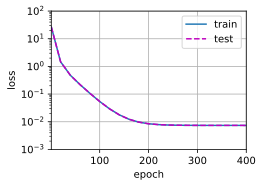

In [8]:
train(poly_features[:n_train,:4], poly_features[:n_train, :4], labels[:n_train], labels[:n_train])

weight: [[2.2572963 5.1851664]]


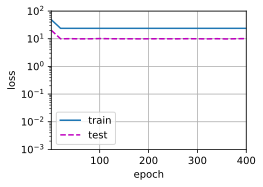

In [15]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.0001936e+00  1.2575436e+00 -3.4237432e+00  5.2934999e+00
   1.2570604e-03  8.3749598e-01  5.8577472e-01 -1.2175574e-01
   2.5543058e-01  1.2285073e-01 -1.6783564e-01  3.0051757e-02
  -1.0195155e-01  1.8387862e-01 -1.9302939e-01  1.8334508e-02
  -1.9514708e-01  1.6282414e-01  5.4535035e-02 -2.8944923e-02]]


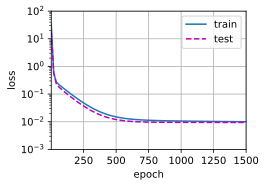

In [16]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)